# Projet PubMedNLP

**Élaboré par :** Nadia BEN YOUSSEF

------

## Phase d'apprentissage

### Préparation des données

##### Importation des bibliothèques 

In [ ]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import os
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, silhouette_samples
from collections import Counter
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
#with open('/kaggle/input/articles-pubmed/articles.json', 'r') as f:
with open('/Users/nadiabenyoussef/Projet PubMedNLP/scraping/articles.json', 'r') as f:
    articles_data = json.load(f)

#with open('/kaggle/input/articles-pubmed/annotated_articles.json', 'r') as f:
with open('/Users/nadiabenyoussef/Projet PubMedNLP/annotation/annotated_articles.json', 'r') as f:
    annotated_data = json.load(f)

print(f"Nombre d'articles originaux : {len(articles_data)}")
print(f"Nombre d'articles annotés : {len(annotated_data)}")

Nombre d'articles originaux : 949
Nombre d'articles annotés : 920


##### Fusion des données dans un DataFrame

In [3]:
merged_data = []

# Parcourir les articles originaux
for article in articles_data:
    pmid = article['pmid']
    # Vérifier si cet article a des annotations
    if pmid in annotated_data:
        merged_entry = {
            'PMID': pmid,
            'Title': article['Article Title'],
            'Abstract': article.get('abstract', ''),  # get() pour éviter erreur si absent
            'DISEASE': annotated_data[pmid]['annotations']['DISEASE'],
            'CELL_TYPE': annotated_data[pmid]['annotations']['CELL_TYPE']
        }
        merged_data.append(merged_entry)

df = pd.DataFrame(merged_data)

print("Aperçu des 5 premières lignes fusionnées :")
print(df.head())

Aperçu des 5 premières lignes fusionnées :
       PMID                                              Title  \
0  39743585  FBP1 controls liver cancer evolution from sene...   
1  39743589  Aspartate signalling drives lung metastasis vi...   
2  39753770  Blood DNA virome associates with autoimmune di...   
3  39755327  Implications of an Off-Hours Setting in Patien...   
4  39753140  Infiltrating plasma cells maintain glioblastom...   

                                            Abstract  \
0  Hepatocellular carcinoma (HCC) originates from...   
1  Lung metastases occur in up to 54% of patients...   
2  Aberrant immune responses to viral pathogens c...   
3                                        Background:   
4  Glioblastoma is a highly aggressive primary br...   

                                             DISEASE  \
0  [Hepatocellular carcinoma, metabolic-dysfuncti...   
1                                    [breast cancer]   
2                               [multiple sclerosis]   

##### Filtrer les articles avec "unspecified disease"

In [4]:
unspecified_count = df['DISEASE'].apply(lambda x: 'unspecified disease' in x).sum()
print(f"Nombre d'articles avec 'unspecified disease' : {unspecified_count}")

df_filtered = df[df['DISEASE'].apply(lambda x: 'unspecified disease' not in x)].reset_index(drop=True)
print(f"Nombre d'articles après filtrage : {len(df_filtered)}")

Nombre d'articles avec 'unspecified disease' : 363
Nombre d'articles après filtrage : 586


In [5]:
df_set = df_filtered.copy() 
df_set['Disease'] = df_set['DISEASE'].apply(lambda x: ' '.join(x))
df_set['Title_Abstract'] = df_set['Title'] + ' ' + df_set['Abstract'].fillna('')

print("Aperçu avec DISEASE comme feature principale :")
print(df_set[['PMID', 'Disease', 'Title_Abstract']].head())

Aperçu avec DISEASE comme feature principale :
       PMID                                            Disease  \
0  39743585  Hepatocellular carcinoma metabolic-dysfunction...   
1  39743589                                      breast cancer   
2  39753770                                 multiple sclerosis   
3  39753140                                       glioblastoma   
4  39753865                           hepatocellular carcinoma   

                                      Title_Abstract  
0  FBP1 controls liver cancer evolution from sene...  
1  Aspartate signalling drives lung metastasis vi...  
2  Blood DNA virome associates with autoimmune di...  
3  Infiltrating plasma cells maintain glioblastom...  
4  ABCF1-K430-Lactylation promotes HCC malignant ...  


##### Vectorisation des données

In [6]:
tfidf = TfidfVectorizer(ngram_range=(1, 3), min_df=3)

disease_tfidf = tfidf.fit_transform(df_set['Disease'])

print(f"Taille de la matrice TF-IDF : {disease_tfidf.shape}")
print("Exemple de termes TF-IDF (40 premiers) :", tfidf.get_feature_names_out()[:40])

Taille de la matrice TF-IDF : (586, 213)
Exemple de termes TF-IDF (40 premiers) : ['acute' 'acute kidney' 'acute kidney injury' 'acute myeloid'
 'acute myeloid leukemia' 'adenocarcinoma' 'alzheimer' 'alzheimer disease'
 'amyotrophic' 'amyotrophic lateral' 'amyotrophic lateral sclerosis'
 'anemia' 'anti' 'apoptosis' 'arthritis' 'associated'
 'associated fibroblasts' 'atherosclerosis' 'autoimmune' 'bladder'
 'bladder cancer' 'bowel' 'bowel disease' 'breast' 'breast cancer'
 'breast cancer breast' 'cancer' 'cancer associated'
 'cancer associated fibroblasts' 'cancer breast' 'cancer breast cancer'
 'cancer cancer' 'cancer cancer therapy' 'cancer cell' 'cancer cell lines'
 'cancer ferroptosis' 'cancer metastatic' 'cancer therapy' 'cancers'
 'carcinoma']


#### Clustering avec K-means


##### K-means avec 5 clusters

In [14]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
clusters = kmeans.fit_predict(disease_tfidf)

df_set['Cluster'] = clusters

print("Aperçu des articles avec leurs clusters :")
print(df_set[['PMID', 'Disease', 'Cluster']].head())

feature_names = tfidf.get_feature_names_out()
centroids = kmeans.cluster_centers_

Aperçu des articles avec leurs clusters :
       PMID                                            Disease  Cluster
0  39743585  Hepatocellular carcinoma metabolic-dysfunction...        3
1  39743589                                      breast cancer        2
2  39753770                                 multiple sclerosis        0
3  39753140                                       glioblastoma        0
4  39753865                           hepatocellular carcinoma        3


In [15]:
print("\nTermes dominants par cluster :")
for i in range(n_clusters):
    top_indices = centroids[i].argsort()[-10:][::-1]
    top_terms = [feature_names[idx] for idx in top_indices]
    print(f"Cluster {i}: {', '.join(top_terms)}")


Termes dominants par cluster :
Cluster 0: disorders, injury, syndrome, osteoarthritis, disorder, fibrosis, acute, ferroptosis, cancers, failure
Cluster 1: disease, cardiovascular disease, cardiovascular, kidney disease, kidney, liver disease, pulmonary disease, pulmonary, liver, alzheimer
Cluster 2: cancer, breast cancer, breast, lung, lung cancer, cell, gastric cancer, gastric, prostate, prostate cancer
Cluster 3: carcinoma, hepatocellular, hepatocellular carcinoma, cell carcinoma, cell, squamous, squamous cell, squamous cell carcinoma, renal, esophageal
Cluster 4: diabetes, in, apoptosis, atherosclerosis, or, arthritis, cardiovascular, cell, fibroblasts, ferroptosis ferroptosis


In [16]:
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df_set[df_set['Cluster'] == i]['Disease'].tolist())


Cluster 0:
['multiple sclerosis', 'glioblastoma', 'necroptosis-related spontaneous enteritis', 'tracheal fibrosis benign airway stenosis', 'Osteoarthritis  heterogeneous disorder Osteoarthritis  heterogeneous', 'cardiovascular-kidney-metabolic syndrome', 'endometriosis', 'Alternative Medicine for Heart Failure', 'Clinicogenomic landscape of pancreatic adenocarcinoma', 'glioblastoma', 'Pancreatic ductal adenocarcinoma', 'age-, disorder studied mediators were not disorder-specific age-, disorder- or treatment-specific mediators', 'macrophage activation syndromes', 'hemorrhagic cystitis', 'Lissencephaly spectrum disorders', 'acute myeloid leukemia', 'OTULIN-related autoinflammatory syndrome', 'autosomal recessive disorder neurodegenerative disorders EEFSEC deficiency', 'heart failure dilated cardiomyopathy', 'immunity activation upon pathogen infection', 'tubular injury acute kidney injury', 'Osteoarthritis', 'idiopathic pulmonary fibrosis', 'osteoarthritis therapeutic approach for osteo

##### K-means avec 6 clusters 

In [10]:
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
clusters = kmeans.fit_predict(disease_tfidf)
df_set['Cluster'] = clusters

print("Aperçu des articles avec k=6 :")
print(df_set[['PMID', 'Disease', 'Cluster']].head())

Aperçu des articles avec k=6 :
       PMID                                            Disease  Cluster
0  39743585  Hepatocellular carcinoma metabolic-dysfunction...        0
1  39743589                                      breast cancer        4
2  39753770                                 multiple sclerosis        0
3  39753140                                       glioblastoma        0
4  39753865                           hepatocellular carcinoma        0


In [11]:
feature_names = tfidf.get_feature_names_out()
centroids = kmeans.cluster_centers_
print("\nTermes dominants par cluster :")
for i in range(n_clusters):
    top_indices = centroids[i].argsort()[-10:][::-1]
    top_terms = [feature_names[idx] for idx in top_indices]
    print(f"Cluster {i}: {', '.join(top_terms)}")


Termes dominants par cluster :
Cluster 0: disorders, carcinoma, syndrome, hepatocellular carcinoma, hepatocellular, osteoarthritis, disorder, fibrosis, injury, ferroptosis
Cluster 1: diabetes, in, apoptosis, atherosclerosis, or, arthritis, cardiovascular, cell, fibroblasts, ferroptosis ferroptosis
Cluster 2: disease, cardiovascular disease, cardiovascular, liver disease, pulmonary disease, pulmonary, liver, system, virus, hepatic
Cluster 3: lung, lung cancer, cancer, cell lung, small cell lung, small cell, small, cell lung cancer, cell, non small
Cluster 4: cancer, breast, breast cancer, gastric cancer, gastric, prostate cancer, prostate, colorectal, colorectal cancer, in
Cluster 5: kidney, acute, kidney injury, kidney disease, acute kidney injury, acute kidney, injury, leukemia, myeloid, disease


Liste complète des Disease par cluster

In [12]:
for i in range(n_clusters):
    print(f"\nCluster {i}:")
    print(df_set[df_set['Cluster'] == i]['Disease'].tolist())


Cluster 0:
['Hepatocellular carcinoma metabolic-dysfunction-associated steatohepatitis', 'multiple sclerosis', 'glioblastoma', 'hepatocellular carcinoma', 'necroptosis-related spontaneous enteritis', 'liver inflammation, fibrosis Hepatocellular carcinoma', 'tracheal fibrosis benign airway stenosis', 'Osteoarthritis  heterogeneous disorder Osteoarthritis  heterogeneous', 'cardiovascular-kidney-metabolic syndrome', 'endometriosis', 'renal clear cell carcinoma renal clear cell carcinoma ferroptosis ferroptosis', 'Alternative Medicine for Heart Failure', 'cancer cell metastasis hepatocellular carcinoma', 'Clinicogenomic landscape of pancreatic adenocarcinoma', 'glioblastoma', 'Pancreatic ductal adenocarcinoma', 'age-, disorder studied mediators were not disorder-specific age-, disorder- or treatment-specific mediators', 'macrophage activation syndromes', 'hemorrhagic cystitis', 'Lissencephaly spectrum disorders', 'OTULIN-related autoinflammatory syndrome', 'nasopharyngeal carcinoma', 'aut

#### Choix du nombre de clusters : 

-> Après avoir effectué le **clustering** avec **K-means** pour **k=5** et **k=6** sur la matrice **TF-IDF** des annotations Disease (586 articles, 213 termes), le choix de k=5 a été retenu comme optimal pour identifier des thématiques médicales cohérentes. 

Avec **k=5**, les clusters obtenus présentent une séparation claire et interprétable : 

- le **Cluster 0** capture respectivement des **troubles variés** (ex. "multiple sclerosis", "glioblastoma").
- le **Cluster 1** réunit les **maladies systémiques d’organes** (ex. "cardiovascular disease", "kidney disease").
- le **Cluster 2** regroupe les **cancers localisés** (ex. "breast cancer", "lung cancer").
- le **Cluster 3** isole les **carcinomes** (ex. "hepatocellular carcinoma", "squamous cell carcinoma").
- le **Cluster 4** se focalise spécifiquement sur le diabète (ex. 'diabetes', 'dyslipidaemia in type 2 diabetes').

En revanche, avec **k=6**, bien que des thématiques spécifiques émergent (ex. Cluster 3 pour "lung cancer", Cluster 5 pour "acute kidney injury" et "acute myeloid leukemia"), le Cluster 0 devient un mélange incohérent incluant "hepatocellular carcinoma", "multiple sclerosis" et "glioblastoma", perdant la distinction nette des carcinomes observée avec k=5. 

De plus, le **score de silhouette (0.159 pour k=5 contre 0.162 pour k=6)** montre une différence minime, mais la simplicité et la lisibilité des **cinq clusters** prévalent pour une analyse thématique pertinente dans le contexte de ce projet.

##### Nettoyage des termes

In [17]:
feature_names = tfidf.get_feature_names_out()
centroids = kmeans.cluster_centers_
stop_words = {'in', 'or'}

print("Termes dominants par cluster (nettoyés) :")
for i in range(5):
    top_indices = centroids[i].argsort()[-10:][::-1]
    top_terms = [feature_names[idx] for idx in top_indices if feature_names[idx] not in stop_words]
    print(f"Cluster {i}: {', '.join(top_terms[:10])}")

Termes dominants par cluster (nettoyés) :
Cluster 0: disorders, injury, syndrome, osteoarthritis, disorder, fibrosis, acute, ferroptosis, cancers, failure
Cluster 1: disease, cardiovascular disease, cardiovascular, kidney disease, kidney, liver disease, pulmonary disease, pulmonary, liver, alzheimer
Cluster 2: cancer, breast cancer, breast, lung, lung cancer, cell, gastric cancer, gastric, prostate, prostate cancer
Cluster 3: carcinoma, hepatocellular, hepatocellular carcinoma, cell carcinoma, cell, squamous, squamous cell, squamous cell carcinoma, renal, esophageal
Cluster 4: diabetes, apoptosis, atherosclerosis, arthritis, cardiovascular, cell, fibroblasts, ferroptosis ferroptosis


In [20]:
cluster_summary = {
    0: "Troubles variés (ex. multiple sclerosis, glioblastoma)",
    1: "Maladies systémiques d’organes (ex. cardiovascular disease, kidney disease)",
    2: "Cancers localisés (ex. breast cancer, lung cancer)",
    3: "Carcinomas (ex. hepatocellular carcinoma, squamous cell carcinoma)",
    4: "Diabète (ex. diabetes, dyslipidaemia in type 2 diabetes)"
}
print("\nRésumé des clusters :")
for i, desc in cluster_summary.items():
    print(f"Cluster {i}: {desc}")


Résumé des clusters :
Cluster 0: Troubles variés (ex. multiple sclerosis, glioblastoma)
Cluster 1: Maladies systémiques d’organes (ex. cardiovascular disease, kidney disease)
Cluster 2: Cancers localisés (ex. breast cancer, lung cancer)
Cluster 3: Carcinomas (ex. hepatocellular carcinoma, squamous cell carcinoma)
Cluster 4: Diabète (ex. diabetes, dyslipidaemia in type 2 diabetes)


##### Visualisation des clusters (k=5)

In [23]:
print("Analyse détaillée des clusters :")
for i in range(5):
    cluster_diseases = df_set[df_set['Cluster'] == i]['Disease'].tolist()
    print(f"\nCluster {i}: {len(cluster_diseases)} articles")

# Exemple
cluster_2_diseases = df_set[df_set['Cluster'] == 2]['Disease'].tolist()
disease_counts_2 = Counter(cluster_2_diseases)
print(f"\nTop 5 Disease les plus fréquents du Cluster 2 ({len(cluster_2_diseases)} articles):")
for disease, count in disease_counts_2.most_common(5):
    print(f"  - {disease}: {count}")

Analyse détaillée des clusters :

Cluster 0: 268 articles

Cluster 1: 86 articles

Cluster 2: 161 articles

Cluster 3: 35 articles

Cluster 4: 36 articles

Top 5 Disease les plus fréquents du Cluster 2 (161 articles):
  - gastric cancer: 5
  - breast cancer: 4
  - Gastric cancer: 4
  - lung cancer: 4
  - colorectal cancer: 4


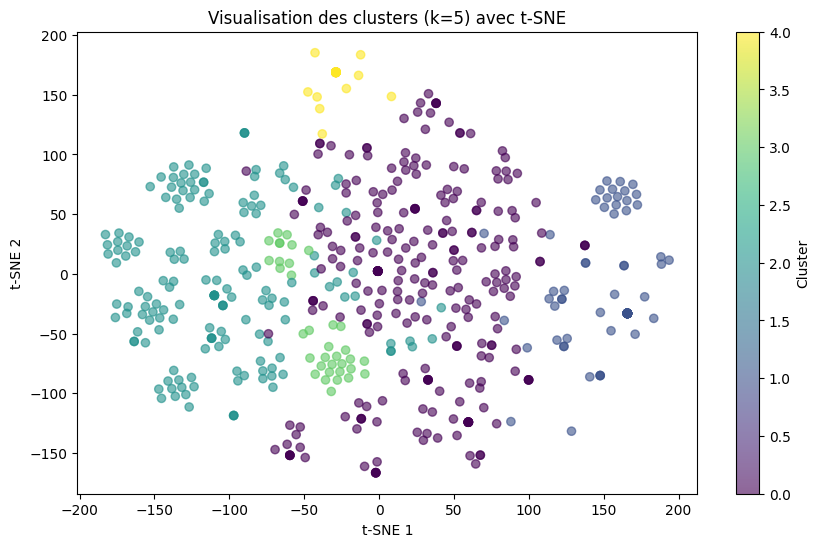

In [19]:
tsne = TSNE(n_components=2, random_state=42)
disease_tsne = tsne.fit_transform(disease_tfidf.toarray())
plt.figure(figsize=(10, 6))
scatter = plt.scatter(disease_tsne[:, 0], disease_tsne[:, 1], c=df_set['Cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title("Visualisation des clusters (k=5) avec t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

Score de silhouette moyen pour k=5 : 0.159


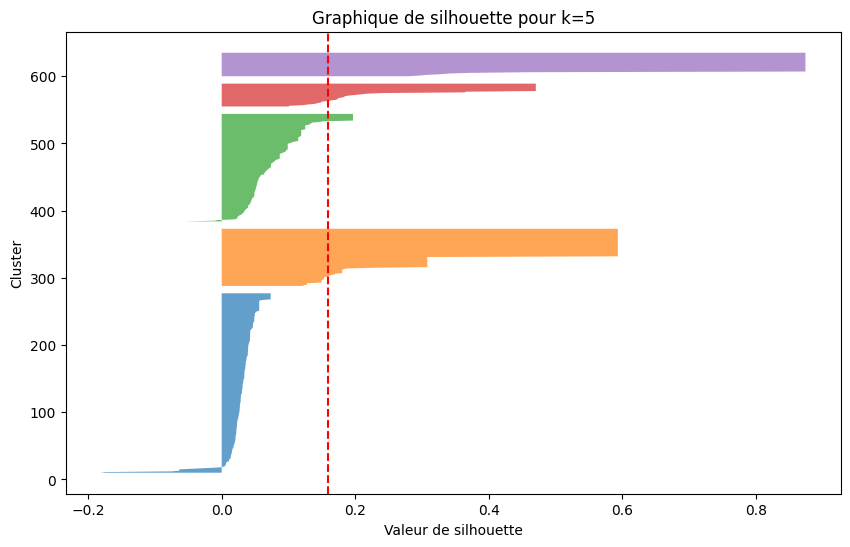

In [21]:
silhouette_avg = silhouette_score(disease_tfidf, df_set['Cluster'])
print(f"Score de silhouette moyen pour k=5 : {silhouette_avg:.3f}")
sample_silhouette_values = silhouette_samples(disease_tfidf, df_set['Cluster'])

fig, ax = plt.subplots(figsize=(10, 6))
y_lower = 10
for i in range(5):
    cluster_values = sample_silhouette_values[df_set['Cluster'] == i]
    cluster_values.sort()
    size_cluster_i = cluster_values.shape[0]
    y_upper = y_lower + size_cluster_i
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_values, alpha=0.7)
    y_lower = y_upper + 10

ax.set_title("Graphique de silhouette pour k=5")
ax.set_xlabel("Valeur de silhouette")
ax.set_ylabel("Cluster")
ax.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.show()

#### Topic Modeling avec LDA sur Disease

In [25]:
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
topics = lda.fit_transform(disease_tfidf)

df_set['Topic'] = topics.argmax(axis=1)

# Afficher les mots clés par topic
print("Mots clés par topic :")
feature_names = tfidf.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    top_terms = [feature_names[j] for j in topic.argsort()[:-11:-1]]
    print(f"Topic {i}: {', '.join(top_terms)}")

Mots clés par topic :
Topic 0: cancer, cardiovascular, ferroptosis, cardiovascular disease, osteoarthritis, in, colorectal, disease, colorectal cancer, cancer cell
Topic 1: cancer, carcinoma, hepatocellular, hepatocellular carcinoma, disorder, breast cancer, breast, liver, cancers, arthritis
Topic 2: disorders, lung, cancer, lung cancer, failure, injury, fibrosis, cell lung, small cell lung, small
Topic 3: diabetes, syndrome, apoptosis, pulmonary, atherosclerosis, associated, anemia, leukemia, inflammatory, bowel
Topic 4: disease, gastric, gastric cancer, carcinoma, adenocarcinoma, cancer, cell carcinoma, respiratory, cardiomyopathy, cell


##### Comparaison entre clusters et topics

In [26]:
print("\nAperçu avec clusters et topics :")
print(df_set[['PMID', 'Disease', 'Cluster', 'Topic']].head())


Aperçu avec clusters et topics :
       PMID                                            Disease  Cluster  Topic
0  39743585  Hepatocellular carcinoma metabolic-dysfunction...        3      1
1  39743589                                      breast cancer        2      1
2  39753770                                 multiple sclerosis        0      0
3  39753140                                       glioblastoma        0      2
4  39753865                           hepatocellular carcinoma        3      1


##### Matrice de correspondance Cluster vs Topic

In [27]:
cross_tab = pd.crosstab(df_set['Cluster'], df_set['Topic'])
print("\nMatrice de correspondance Cluster vs Topic :")
print(cross_tab)


Matrice de correspondance Cluster vs Topic :
Topic     0   1   2   3   4
Cluster                    
0        50  54  64  63  37
1        16   7   2   8  53
2        40  46  47   7  21
3         1  20   0   0  14
4         2   1   0  33   0


#### Analyse des résultats du Topic Modeling (LDA)
L’analyse LDA avec 5 topics sur la matrice TF-IDF des annotations `Disease` révèle des thématiques complémentaires aux clusters K-means. 

- Le **Topic 1** ("carcinoma, hepatocellular, breast cancer") correspond fortement au **Cluster 3** (carcinomas), regroupant 20 de ses 35 articles, et inclut aussi "breast cancer" du **Cluster 2** (46 articles), suggérant un chevauchement cancer/carcinome.
- Le **Topic 3** ("diabetes, syndrome, atherosclerosis") aligne presque parfaitement **le Cluster 4** (33/36 articles), confirmant sa spécificité au diabète.
- Le **Topic 2** ("lung cancer, disorders") capte une partie du **Cluster 2** (47 articles) avec un focus sur les cancers pulmonaires, tandis que les **Topics 0 et 4**, plus variés ("cardiovascular, colorectal" et "gastric, adenocarcinoma"), dispersent les **Clusters 0 et 1** (troubles variés et maladies d’organes).

La **matrice de correspondance** montre une répartition diffuse pour le **Cluster 0** (50-64 articles par topic), reflétant son hétérogénéité, alors que les **Clusters 3 et 4** sont plus concentrés. 

-> Cette analyse LDA enrichit le clustering en affinant certaines thématiques.

#### Visualisation des topics LDA

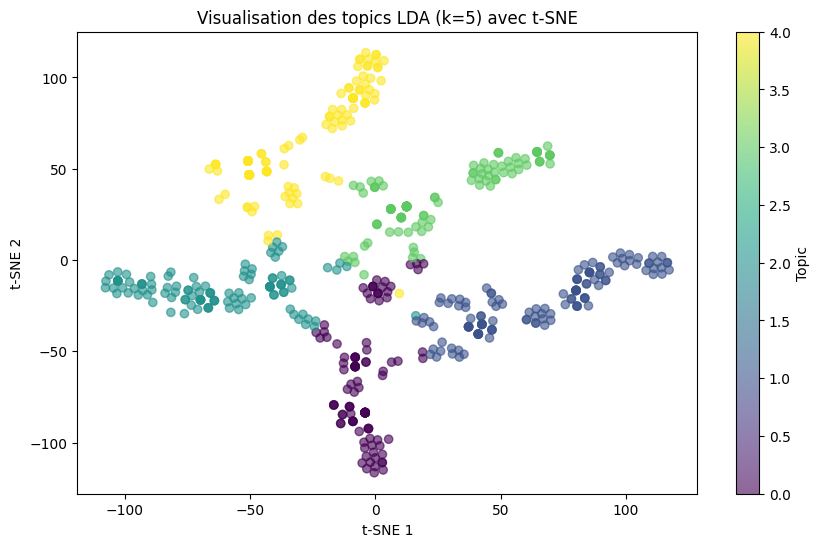

In [28]:
# t-SNE sur la matrice de topics
tsne = TSNE(n_components=2, random_state=42)
topics_tsne = tsne.fit_transform(topics)

plt.figure(figsize=(10, 6))
scatter = plt.scatter(topics_tsne[:, 0], topics_tsne[:, 1], c=df_set['Topic'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Topic')
plt.title("Visualisation des topics LDA (k=5) avec t-SNE")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

In [36]:
print("Exemples de Disease par Cluster et Topic :")
for cluster in range(5):
    for topic in range(5):
        subset = df_set[(df_set['Cluster'] == cluster) & (df_set['Topic'] == topic)]
        if len(subset) > 0:
            examples = subset['Disease'].head(3).tolist()
            print(f"Cluster {cluster} - Topic {topic} ({len(subset)} articles): {examples}")
    print("-------------------------------------------------------------------------------------------")            

Exemples de Disease par Cluster et Topic :
Cluster 0 - Topic 0 (50 articles): ['multiple sclerosis', 'Osteoarthritis  heterogeneous disorder Osteoarthritis  heterogeneous', 'cardiovascular-kidney-metabolic syndrome']
Cluster 0 - Topic 1 (54 articles): ['necroptosis-related spontaneous enteritis', 'age-, disorder studied mediators were not disorder-specific age-, disorder- or treatment-specific mediators', 'OTULIN-related autoinflammatory syndrome']
Cluster 0 - Topic 2 (64 articles): ['glioblastoma', 'tracheal fibrosis benign airway stenosis', 'Alternative Medicine for Heart Failure']
Cluster 0 - Topic 3 (63 articles): ['macrophage activation syndromes', 'acute myeloid leukemia', 'idiopathic pulmonary fibrosis']
Cluster 0 - Topic 4 (37 articles): ['Clinicogenomic landscape of pancreatic adenocarcinoma', 'Pancreatic ductal adenocarcinoma', 'autosomal recessive disorder neurodegenerative disorders EEFSEC deficiency']
------------------------------------------------------------------------

#### Analyse des exemples Cluster vs Topic

Les exemples par combinaison Cluster/Topic montrent une correspondance partielle entre les deux méthodes : 
- le Cluster 3 (carcinomas) se concentre dans le Topic 1 (20 articles, ex. "hepatocellular carcinoma").
- le Cluster 4 (diabetes) domine le Topic 3 (33 articles, ex. "diabetes").
- le Cluster 2 (cancers localisés) se disperse entre les Topics 0, 1, et 2 (ex. "breast cancer", "lung cancer").
- Le Cluster 0 (troubles variés) reste hétérogène, avec des `Disease` variés comme "glioblastoma" (Topic 2) et "multiple sclerosis" (Topic 0), reflétant sa diversité. 

Cette répartition souligne que LDA affine certaines thématiques (diabète, carcinomes) mais dilue d’autres (cancers localisés).

### Conclusion

Cette analyse a permis de classer **586 articles PubMed** en **5 thématiques médicales** via **K-means** sur les annotations **`Disease`**. 

Les **5 clusters** identifiés (cancers localisés, carcinomas, maladies d’organes, diabète, troubles variés) reflètent des groupes pertinents. 

La **visualisation t-SNE** et le **score de silhouette (0.159)** confirment une séparation raisonnable. 

**L’analyse LDA** (**5 topics**) complète ces résultats en affinant certains thèmes (ex. Topic 1 pour carcinomas, Topic 3 pour diabète). 

-> Ces deux approches confirment la présence de groupes médicaux distincts dans le corpus, avec une prédominance de cancers et maladies métaboliques.